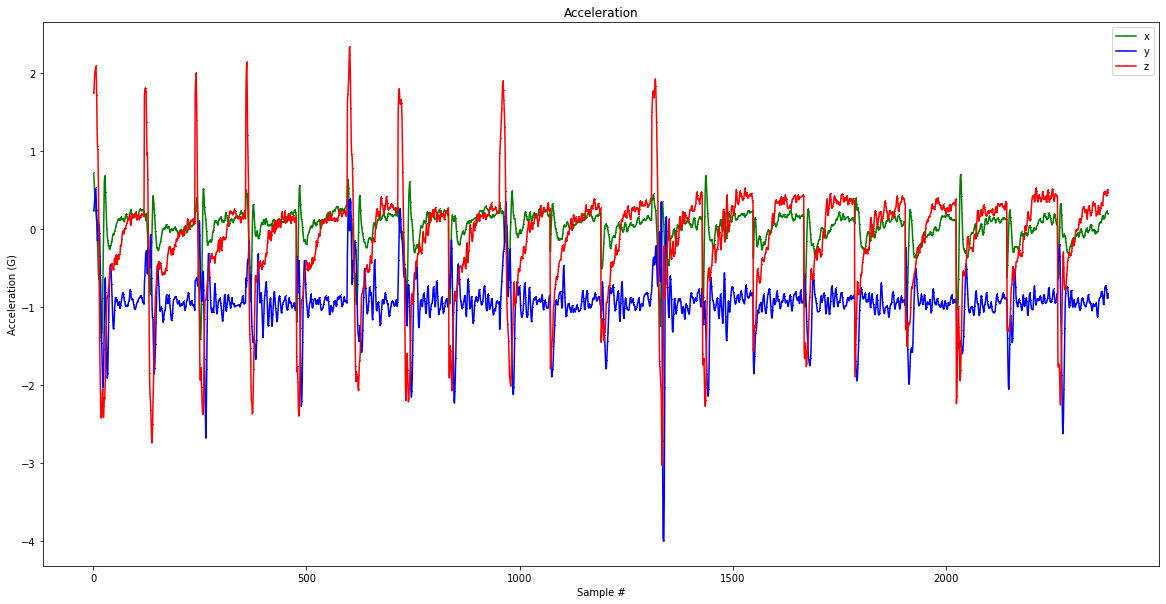

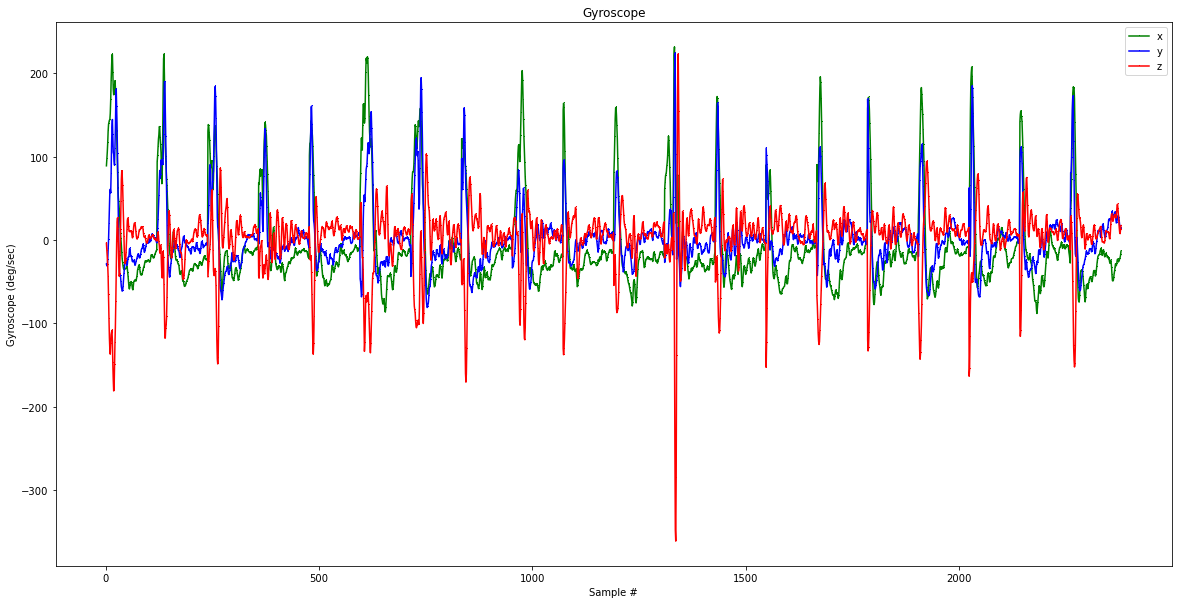

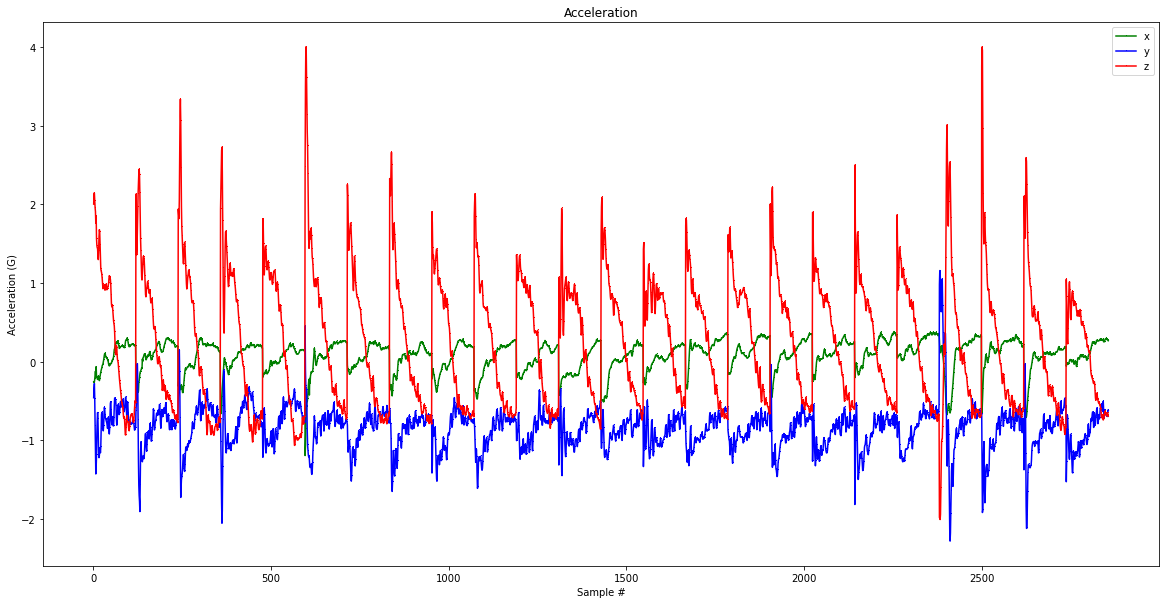

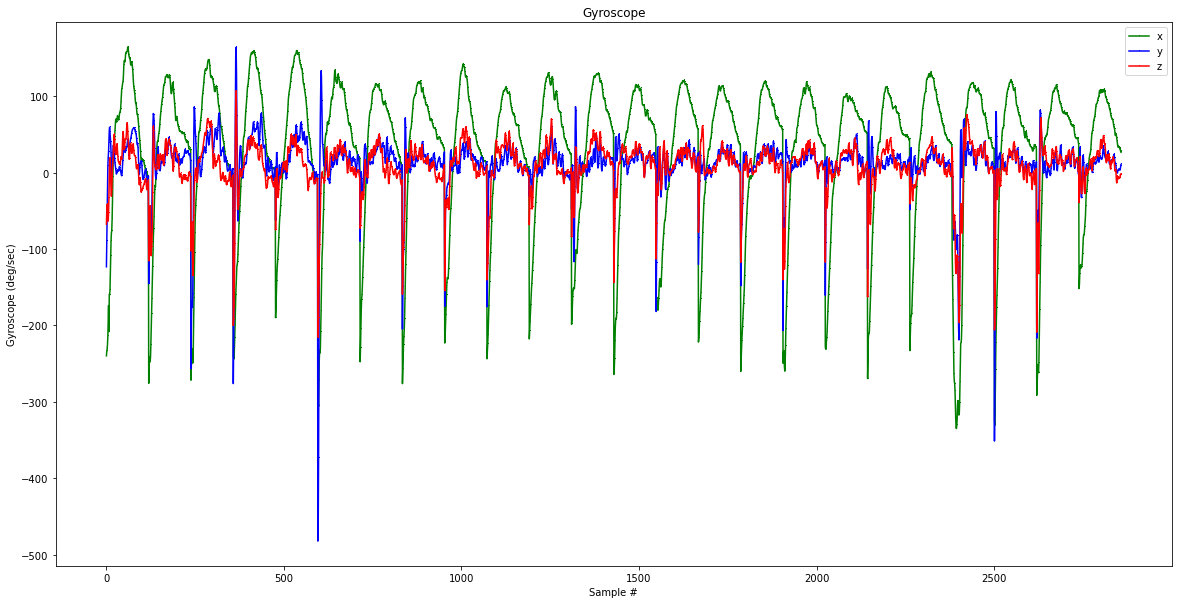

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

# the list of gestures that data is available for
GESTURES = [
    "punch",
    "curl",
]

SAMPLES_PER_GESTURE = 119

NUM_GESTURES = len(GESTURES)

for gesture in GESTURES:
    filename = gesture + '.csv'
    df = pd.read_csv(filename)

    index = range(1, len(df['aX']) + 1)

    plt.rcParams["figure.figsize"] = (20,10)

    plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
    plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
    plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
    plt.title("Acceleration")
    plt.xlabel("Sample #")
    plt.ylabel("Acceleration (G)")
    plt.legend()
    plt.show()

    plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
    plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
    plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
    plt.title("Gyroscope")
    plt.xlabel("Sample #")
    plt.ylabel("Gyroscope (deg/sec)")
    plt.legend()
    plt.show()

In [2]:
import numpy as np

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_random_seed(SEED)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
    gesture = GESTURES[gesture_index]
    print(f"Processing index {gesture_index} for gesture '{gesture}'.")
    
    output = ONE_HOT_ENCODED_GESTURES[gesture_index]
    
    df = pd.read_csv(gesture + ".csv")
    
    # calculate the number of gesture recordings in the file
    num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
    
    print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
    
    for i in range(num_recordings):
        tensor = []
        for j in range(SAMPLES_PER_GESTURE):
            index = i * SAMPLES_PER_GESTURE + j
            # normalize the input data, between 0 to 1:
            # - acceleration is between: -4 to +4
            # - gyroscope is between: -2000 to +2000
            tensor += [
                (df['aX'][index] + 4) / 8,
                (df['aY'][index] + 4) / 8,
                (df['aZ'][index] + 4) / 8,
                (df['gX'][index] + 2000) / 4000,
                (df['gY'][index] + 2000) / 4000,
                (df['gZ'][index] + 2000) / 4000
            ]

            inputs.append(tensor)
            outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

TensorFlow version = 1.15.4

Processing index 0 for gesture 'punch'.
	There are 20 recordings of the punch gesture.
Processing index 1 for gesture 'curl'.
	There are 24 recordings of the curl gesture.
Data set parsing and preparation complete.


In [3]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


In [4]:
#uncomment to force CPU
tf.config.experimental.set_visible_devices([], "DML")
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=10, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 3141 samples, validate on 1048 samples
Epoch 1/10
3141/3141 [==============================] - 12s 4ms/sample - loss: 0.0569 - mean_absolute_error: 0.1436 - val_loss: 4.2162e-05 - val_mean_absolute_error: 0.0036
Epoch 2/10
3141/3141 [==============================] - 11s 4ms/sample - loss: 4.1852e-05 - mean_absolute_error: 0.0011 - val_loss: 9.9409e-09 - val_mean_absolute_error: 6.4463e-05
Epoch 3/10
3141/3141 [==============================] - 14s 5ms/sample - loss: 1.6229e-07 - mean_absolute_error: 6.0663e-05 - val_loss: 1.2469e-10 - val_mean_absolute_error: 6.5137e-06
Epoch 4/10
3141/3141 [==============================] - 14s 5ms/sample - loss: 9.6896e-11 - mean_absolute_error: 5.2958e-06 - val_loss: 6.7012e-11 - val_mean_absolute_error: 4.6666e-06
Epoch 5/10
3141/3141 [==============================] - 16s 5ms/sample - loss: 4.9495e-11 - mean_absolute_error: 3.8664e-06 - val_loss: 3.5933e-11 

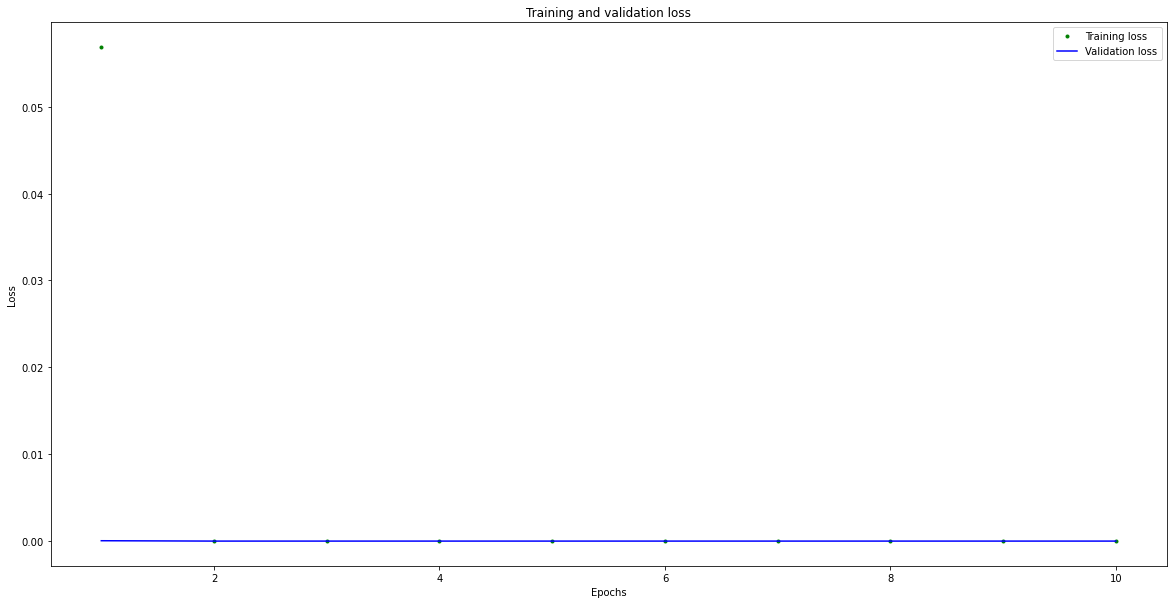

[20.0, 10.0]


In [5]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

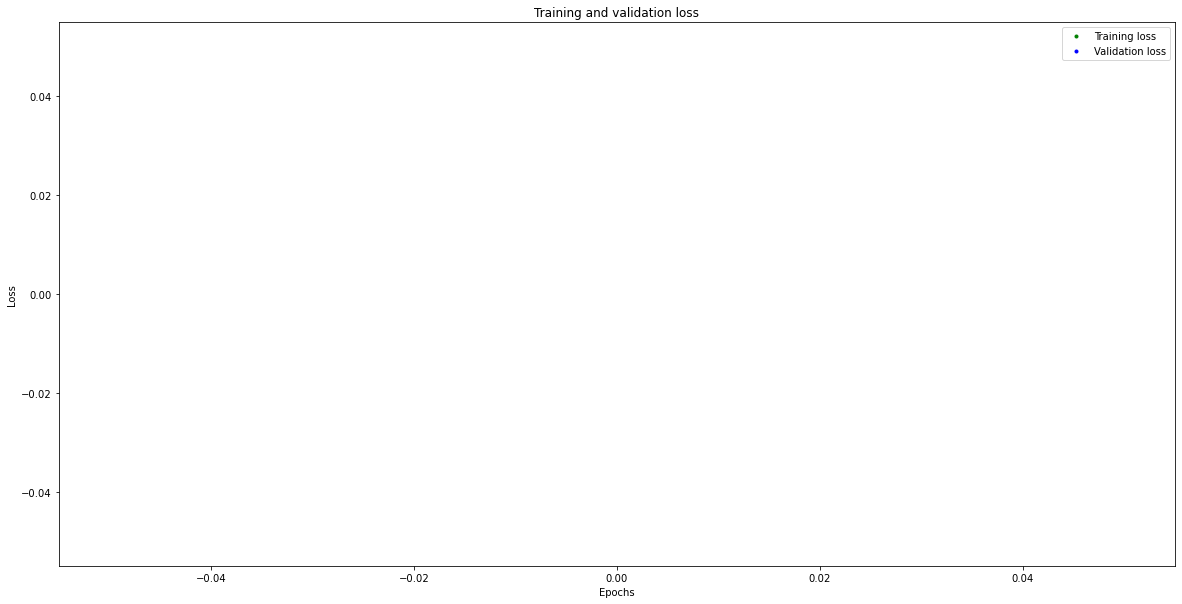

In [6]:
# graph the loss again skipping a bit at the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

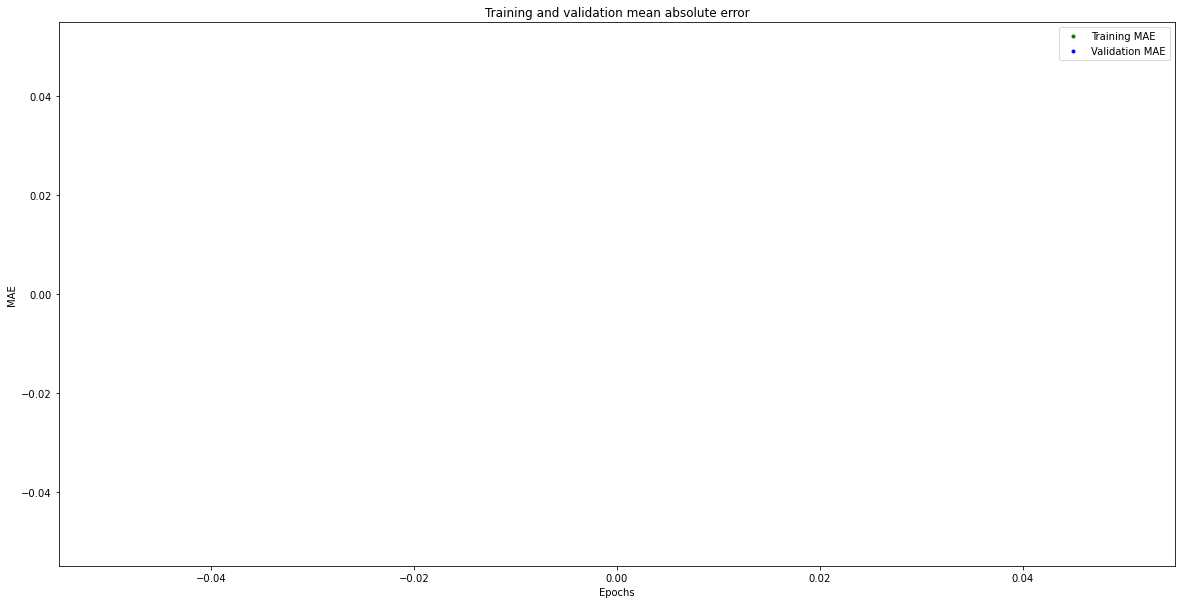

In [7]:
# graph of mean absolute error
mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [8]:
model.save('my_model', True, True, 'tf')
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model_file('my_model')
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  

INFO:tensorflow:Assets written to: my_model\assets
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 6 variables.
INFO:tensorflow:Converted 6 variables to const ops.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


ConverterError: See console for info.
2021-01-07 19:00:44.895468: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2
2021-01-07 19:00:45.434574: I tensorflow/stream_executor/platform/default/dso_loader.cc:98] Successfully opened dynamic library c:\users\konst\miniconda3\envs\arduino_ml\lib\site-packages\tensorflow_core\python/directml.bdb07c797e1af1b4a42d21c67ce5494d73991459.dll
2021-01-07 19:00:45.606477: I tensorflow/core/common_runtime/dml/dml_device_cache.cc:126] DirectML device enumeration: found 2 compatible adapters.
2021-01-07 19:00:45.607476: I tensorflow/core/common_runtime/dml/dml_device_cache.cc:109] DirectML: creating device on adapter 0 (NVIDIA GeForce GTX 1050)
2021-01-07 19:00:45.896013: I tensorflow/core/common_runtime/dml/dml_device_cache.cc:109] DirectML: creating device on adapter 1 (Intel(R) UHD Graphics 620)
2021-01-07 19:00:45.994858: E tensorflow/lite/toco/import_tensorflow.cc:2241] tensorflow::ImportGraphDef failed with status: Invalid argument: Input 1 of node sequential/dense/StatefulPartitionedCall was passed float from sequential/dense/kernel:0 incompatible with expected resource.
2021-01-07 19:00:45.998266: I tensorflow/lite/toco/import_tensorflow.cc:659] Converting unsupported operation: StatefulPartitionedCall
2021-01-07 19:00:45.998950: F tensorflow/lite/toco/import_tensorflow.cc:114] Check failed: attr.value_case() == AttrValue::kType (1 vs. 6)
Fatal Python error: Aborted

Current thread 0x00004b74 (most recent call first):
  File "c:\users\konst\miniconda3\envs\arduino_ml\lib\site-packages\tensorflow_core\lite\toco\python\toco_from_protos.py", line 52 in execute
  File "c:\users\konst\miniconda3\envs\arduino_ml\lib\site-packages\absl\app.py", line 251 in _run_main
  File "c:\users\konst\miniconda3\envs\arduino_ml\lib\site-packages\absl\app.py", line 303 in run
  File "c:\users\konst\miniconda3\envs\arduino_ml\lib\site-packages\tensorflow_core\python\platform\app.py", line 40 in run
  File "c:\users\konst\miniconda3\envs\arduino_ml\lib\site-packages\tensorflow_core\lite\toco\python\toco_from_protos.py", line 89 in main
  File "C:\Users\konst\miniconda3\envs\arduino_ml\Scripts\toco_from_protos.exe\__main__.py", line 7 in <module>
  File "c:\users\konst\miniconda3\envs\arduino_ml\lib\runpy.py", line 85 in _run_code
  File "c:\users\konst\miniconda3\envs\arduino_ml\lib\runpy.py", line 193 in _run_module_as_main




In [19]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
plt.plot(inputs_test, predictions, 'r.', label='Predicted')
plt.show()

predictions =
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
actual =
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


ValueError: x has 714 columns but y has 2 columns

In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")